# Two Moons Simformer Conditional Flow Matching Example
---
This notebook demonstrates conditional flow-matching on the Two Moons task using JAX and Flax. 

**About Simulation-Based Inference (SBI):** SBI refers to a class of methods for inferring parameters of complex models when the likelihood function is intractable, but simulation is possible. SBI algorithms learn to approximate the posterior distribution over parameters given observed data, enabling inference in scientific and engineering domains where traditional methods fail.

**The Two Moons Dataset:**
The Two Moons dataset is a two-dimensional simulation-based inference benchmark designed to test an algorithm's ability to handle complex posterior distributions. Its posterior is both bimodal (two distinct peaks) and locally crescent-shaped, making it a challenging task for inference algorithms. The primary purpose of this benchmark is to evaluate how well different methods can capture and represent multimodality and intricate structure in the posterior.

**Purpose of This Notebook:**
This notebook trains and evaluates a Simformer flow-matching model on the Two Moons task. The goal is to assess the model's ability to learn and represent a non-trivial posterior distribution with both global (bimodal) and local (crescent-shaped) complexity.

## Table of Contents
| Section | Description |
|---|---|
| [1. Introduction & Setup](#1-introduction--setup) | Overview, environment, device, autoreload |
| [2. Task & Data Preparation](#2-task--data-preparation) | Define task, visualize data, create datasets |
| [3. Model Configuration & Definition](#3-model-configuration--definition) | Load config, set parameters, instantiate model |
| [4. Training](#4-training) | Train or restore model, manage checkpoints |
| [5. Evaluation & Visualization](#5-evaluation--visualization) | Visualize loss, sample posterior, compute log prob |
| [6. Animations](#6-animations) | Create and display GIFs of results |

## 1. Introduction & Setup
---
In this section, we introduce the problem, set up the computational environment, import required libraries, configure JAX for CPU or GPU usage, and enable autoreload for iterative development. Compatibility with Google Colab is also ensured.

In [1]:
# Check if running on Colab and install dependencies if needed
try:
    import google.colab
    colab = True
except ImportError:
    colab = False

if colab:
    # Install required packages and clone the repository
    %pip install "gensbi_examples[cuda12] @ git+https://github.com/aurelio-amerio/GenSBI-examples"
    !git clone https://github.com/aurelio-amerio/GenSBI-examples
    %cd GenSBI-examples/examples/sbi-benchmarks/two_moons

In [2]:
# load autoreload extension
%load_ext autoreload
%autoreload 2

In [ ]:
import os
# select device

# os.environ["JAX_PLATFORMS"] = "cuda" 
os.environ["JAX_PLATFORMS"] = "cpu" 

## 2. Task & Data Preparation
---
In this section, we define the Two Moons task, visualize reference samples, and create the training and validation datasets required for model learning. Batch size and sample count are set for reproducibility and performance.

In [4]:
restore_model=True
train_model=False

In [5]:
import orbax.checkpoint as ocp
# get the current notebook path
notebook_path = os.getcwd()
checkpoint_dir = os.path.join(notebook_path, "checkpoints", f"two_moons_flow_simformer")
os.makedirs(checkpoint_dir, exist_ok=True)

In [6]:
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
from flax import nnx

from numpyro import distributions as dist
import numpy as np


In [7]:
from gensbi.utils.plotting import plot_marginals

In [8]:
from gensbi_examples.tasks import TwoMoons
task = TwoMoons()

/lhome/ific/a/aamerio/miniforge3/envs/gensbi/lib/python3.12/site-packages/google/protobuf/runtime_version.py:98: UserWarning: Protobuf gencode version 5.28.3 is exactly one major version older than the runtime version 6.31.1 at grain/proto/execution_summary.proto. Please update the gencode to avoid compatibility violations in the next runtime release.
  warnings.warn(


./task_data/data_two_moons.npz already exists, skipping download.


In [ ]:
# reference posterior for an observation
obs, reference_samples = task.get_reference(num_observation=8)

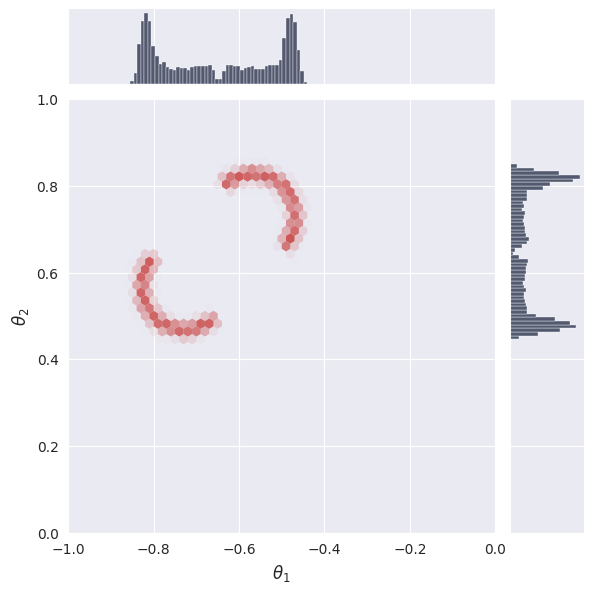

In [ ]:
# plot the 2D posterior 
plot_marginals(np.asarray(reference_samples, dtype=np.float32), gridsize=50,range=[(-1,0),(0,1)], plot_levels=False, backend="seaborn")
plt.show()

In [11]:
# make a dataset
nsamples = int(1e5)

In [ ]:
# Set batch size for training. Larger batch sizes help prevent overfitting, but are limited by available GPU memory.
batch_size = 4096
# Create training and validation datasets using the Two Moons task object.
train_dataset = task.get_train_dataset(batch_size)
val_dataset = task.get_val_dataset()

# Create iterators for the training and validation datasets.
dataset_iter = iter(train_dataset)
val_dataset_iter = iter(val_dataset)

## 3. Model Configuration & Definition
---
In this section, we load the model and optimizer configuration, set all relevant parameters, and instantiate the Simformer model. Edge masks and marginalization functions are used for flexible inference and posterior estimation.

In [13]:
from gensbi.models import SimformerParams, Flux1Params
from gensbi.recipes import SimformerFlowPipeline, SimformerDiffusionPipeline, Flux1FlowPipeline, Flux1DiffusionPipeline

In [ ]:
import yaml

# Path to the Simformer flow-matching configuration file.
config = f"{notebook_path}/config/config_flow_simformer.yaml"

# Load configuration parameters from YAML file.
with open(config, "r") as f:
    config = yaml.safe_load(f)

In [ ]:
# Extract dimensionality information from the task object.
dim_theta = task.dim_theta.item()  # Number of parameters to infer
dim_data = task.dim_data.item()    # Number of observed data dimensions

dim_joint = task.dim_joint.item()  # Joint dimension (for model input)
node_ids = jnp.arange(dim_joint)   # Node indices for model graph

In [ ]:
# Extract training configuration from loaded config.
train_params = config.get("training", {})
experiment_id = train_params.get("experiment_id", 1)  # Unique ID for experiment tracking
# restore_model = train_params.get("restore_model", False)
# train_model = train_params.get("train_model", True)
batch_size = train_params.get("batch_size", 4096)      # Training batch size
nsteps = train_params.get("nsteps", 10000)              # Number of training steps
nepochs = train_params.get("nepochs", 3)                # Number of training epochs
multistep = train_params.get("multistep", 1)            # Multistep training flag
early_stopping = train_params.get("early_stopping", True) # Enable early stopping
print_every = train_params.get("print_every", 100)       # Print loss every N steps

In [ ]:
# Extract optimizer configuration from loaded config.
opt_params = config.get("optimizer", {})
PATIENCE = opt_params.get("patience", 10)           # Early stopping patience
COOLDOWN = opt_params.get("cooldown", 2)            # Cooldown period for LR scheduler
FACTOR = opt_params.get("factor", 0.5)              # LR reduction factor
ACCUMULATION_SIZE = opt_params.get("accumulation_size", 100) # Gradient accumulation steps
RTOL = opt_params.get("rtol", 1e-4)                 # Relative tolerance for stopping
MAX_LR = opt_params.get("max_lr", 1e-3)              # Maximum learning rate
MIN_LR = opt_params.get("min_lr", 0.0)               # Minimum learning rate
MIN_SCALE = MIN_LR / MAX_LR if MAX_LR > 0 else 0.0   # Minimum LR scale

In [ ]:
# Define the model parameters. In general, it is better to define a deeper model with more layers and heads, and a smaller dimension per head.
model_params = config.get("model", {})
params = SimformerParams(
    rngs=nnx.Rngs(0),
    dim_value=model_params.get("dim_value", 40),
    dim_id=model_params.get("dim_id", 40),
    dim_condition=model_params.get("dim_condition", 10),
    dim_joint=dim_joint,
    fourier_features=model_params.get("fourier_features", 128),
    num_heads=model_params.get("num_heads", 6),
    num_layers=model_params.get("num_layers", 8),
    widening_factor=model_params.get("widening_factor", 3),
    qkv_features=model_params.get("qkv_features", 90),
    num_hidden_layers=model_params.get("num_hidden_layers", 1),
)

In [ ]:
# We adopt the default training config, and modify some parameters according to the configuration file
training_config = SimformerFlowPipeline._get_default_training_config()

# overwrite the defaults with the config file values
training_config["num_steps"] = nsteps
training_config["ema_decay"] = 0.999
training_config["patience"] = PATIENCE
training_config["cooldown"] = COOLDOWN
training_config["factor"] = FACTOR
training_config["accumulation_size"] = ACCUMULATION_SIZE
training_config["rtol"] = RTOL
training_config["max_lr"] = MAX_LR
training_config["min_lr"] = MIN_LR
training_config["min_scale"] = MIN_SCALE
training_config["val_every"] = 100
training_config["early_stopping"] = early_stopping
training_config["experiment_id"] = experiment_id
training_config["multistep"] = multistep
training_config["checkpoint_dir"] = checkpoint_dir

In [ ]:
pipeline = SimformerFlowPipeline(train_dataset, val_dataset, dim_theta, dim_data, params=params, training_config=training_config)

## 4. Training
---
In this section, we train the Simformer model using the defined optimizer and loss function, or restore a pretrained model from disk if available. Training is managed with early stopping and learning rate scheduling to improve efficiency and prevent overfitting. Checkpoints are saved for reproducibility and future evaluation.

In [24]:
if restore_model:
    print(f"Restoring model from {checkpoint_dir}")
    pipeline.restore_model(experiment_id=experiment_id)
if train_model:
    print(f"Training model...")
    loss_array, val_loss_array = pipeline.train(rngs=nnx.Rngs(0))


Restoring model from /lustre/ific.uv.es/ml/ific088/github/GenSBI-examples/examples/sbi-benchmarks/two_moons/checkpoints/two_moons_flow_simformer


Restored model from checkpoint


## 5. Evaluation & Visualization
---
In this section, we evaluate the trained Simformer model by visualizing training and validation loss curves, sampling from the posterior, and comparing results to reference data. We also compute and visualize the unnormalized log probability over a grid to assess model calibration and density estimation. These analyses provide insight into model performance and reliability.

In [23]:
if train_model:
    plt.plot(loss_array, label="train loss")
    plt.plot(val_loss_array, label="val loss")
    plt.xlabel("steps")
    plt.ylabel("loss")
    plt.legend()
    plt.show()

## Section 8: Posterior Sampling
---
In this section, we sample from the posterior distribution using the trained model and visualize the results. Posterior samples are generated for a selected observation and compared to reference samples to assess model accuracy.

In [24]:
# we want to do conditional inference. We need an observation for which we want to ocmpute the posterior
def get_samples(idx, nsamples=10_000, use_ema=False, rng=None):
    observation, reference_samples = task.get_reference(idx)
    true_param = jnp.array(task.get_true_parameters(idx))

    if rng is None:
        rng = jax.random.PRNGKey(42)

    time_grid = jnp.linspace(0,1,100)

    samples = pipeline.sample(rng, observation, nsamples, use_ema=use_ema, time_grid=time_grid)
    return samples, true_param, reference_samples

In [25]:
samples, true_param, reference_samples =  get_samples(8)

In [26]:
samples.shape

(100, 10000, 2)

### Section 8.1: Visualize Posterior Samples
---
In this section, we plot the posterior samples as a 2D histogram to visualize the learned distribution and compare it to the ground truth.

In [35]:
from gensbi.utils.plotting import plot_marginals, plot_2d_dist_contour

<Figure size 640x480 with 0 Axes>

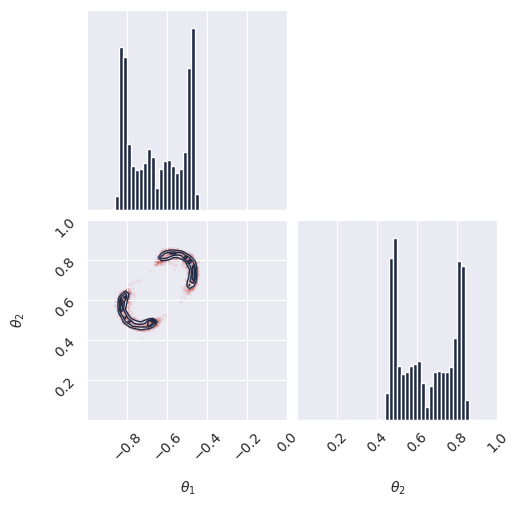

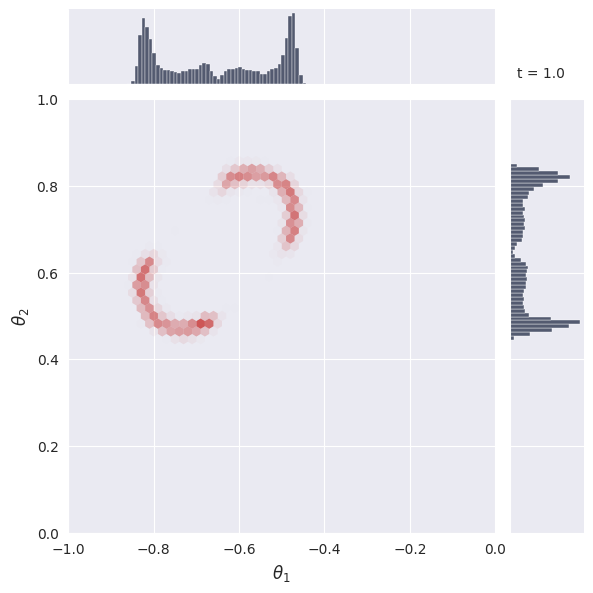

In [28]:
plot_marginals(samples[-1], plot_levels=False, gridsize=50, range=[(-1., 0), (0, 1.)])
plt.show()

# check how we set the ranges in the seaborn plot, it seems wrong
plot_marginals(samples[-1], plot_levels=False, backend="seaborn", gridsize=50, range =[(-1., 0), (0, 1.)])
plt.text(1.05, 1.05, f"t = {1.0}", transform=plt.gca().transAxes)
plt.show()

## Section 9: Compute Unnormalized Log Probability
---
In this section, we compute the unnormalized log probability of the posterior over a grid of parameter values. This allows us to visualize the density and evaluate the calibration of the model.

In [56]:
grid_size = 200

theta1 = jnp.linspace(-1, 0, grid_size)
theta2 = jnp.linspace(0, 1, grid_size)
x_1 = jnp.meshgrid(theta1, theta2)

x_1 = jnp.stack([x_1[0].flatten(), x_1[1].flatten()], axis=1)

observation, reference_samples = task.get_reference(8)

In [57]:
time_grid = jnp.linspace(1,0,100)
p_ = pipeline.compute_unnorm_logprob(x_1, observation, step_size=0.01, use_ema=True, time_grid=time_grid)

In [58]:
x = theta1
y = theta2
Z = np.array(p_.reshape((p_.shape[0], grid_size, grid_size)))

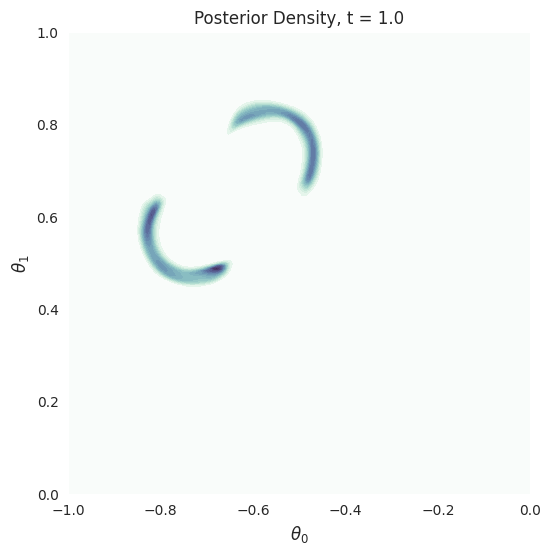

In [60]:
plot_2d_dist_contour(x,y,Z[-1], levels=None)
plt.title("Posterior Density, t = 1.0")
plt.xlabel(r"$\theta_0$", fontsize=12)
plt.ylabel(r"$\theta_1$", fontsize=12)
plt.show()

## 6. Animations
---
In this section, we create and display animations of posterior samples and density contours over time. These visualizations illustrate the evolution of the learned distribution during the sampling process, providing dynamic insight into model behavior and convergence.

In [46]:
import imageio.v3 as imageio
import io
from tqdm import tqdm

In [47]:
# samples

images = []

for i in tqdm(range(len(samples))):
    plot_marginals(
        samples[i],
        plot_levels=False,
        gridsize=50,
        range=[(-1.0, 0), (0, 1.0)],
        backend="seaborn",
    )

    plt.text(1.05, 1.05, f"t = {(i+1)/len(samples):.2f}", transform=plt.gca().transAxes)

    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight', dpi=300)
    buf.seek(0)
    image = imageio.imread(buf)
    buf.close()
    if i == 0:
        images = []
    images.append(image)
    plt.close()

100%|██████████| 100/100 [00:32<00:00,  3.10it/s]


In [48]:
# repeat the last frame 10 times to make the gif pause at the end
images += [images[-1]] * 20

In [ ]:
imageio.imwrite(
    'animated_plot_samples_simformer.gif', 
    images, 
    duration=5000/len(images), 
    loop=0  # 0 means loop indefinitely
)

<img src="./animated_plot_samples.gif" alt="two-moons posterior sampling" width="500">

In [61]:
images = []

for i in tqdm(range(len(samples))):
    plot_2d_dist_contour(x,y,Z[i], levels=None)
    plt.title(f"Posterior Density, t = {(i+1)/len(samples):.2f}")
    plt.xlabel(r"$\theta_0$", fontsize=12)
    plt.ylabel(r"$\theta_1$", fontsize=12)

    buf = io.BytesIO()
    plt.savefig(buf, format="png", bbox_inches='tight', dpi=300)
    buf.seek(0)
    image = imageio.imread(buf)
    buf.close()
    if i == 0:
        images = []
    images.append(image)
    plt.close()

100%|██████████| 100/100 [00:16<00:00,  6.23it/s]


In [62]:
# repeat the last frame 10 times to make the gif pause at the end
images += [images[-1]] * 20

In [ ]:
imageio.imwrite(
    'animated_plot_posterior_simformer.gif', 
    images, 
    duration=5000/len(images), 
    loop=0  # 0 means loop indefinitely
)

<img src="./animated_plot_posterior.gif" alt="two-moons posterior" width="500">